In [1]:
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import sys
import os

# Add project root to path - adjust the number of parent dirs (..) based on where your notebook is located
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils import utils

importlib.reload(utils)

# InteractiveShell.ast_node_interactivity = "all"

# Exploratory Data Analysis of Pacman gathered data (Updated to 2024-12-30)

In [2]:
## Read tables from csv
BANNED_USERS = [42]

user_df = pd.read_csv("../data/user.csv")
ip_df = pd.read_csv("../data/userip.csv")
redcap_df = pd.read_csv("../data/redcapdata.csv")
game_df = pd.read_csv(
    "../data/game.csv", converters={"date_played": lambda x: pd.to_datetime(x)}
)
game_df = game_df[~game_df["user_id"].isin(BANNED_USERS)]  # Remove user 42 (myself)
# game_df = game_df[game_df['user_id'] != 47]
gamestate_df = pd.read_csv(
    "../data/gamestate.csv", converters={"user_id": lambda x: int(x)}
)
gamestate_df = gamestate_df[
    ~gamestate_df["game_id"].isin(
        game_df.loc[game_df["user_id"].isin(BANNED_USERS), "game_id"]
    )
]  # Remove games associated with userid 42 (myself)
psychometrics_df = pd.read_csv("..\data\psych\AiPerCogPacman_DATA_2025-04-01_1343.csv")

In [3]:
## Inspect data

user_df.info()
game_df.info()
gamestate_df.info()


user_df.head()
game_df.head()
gamestate_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   150 non-null    int64 
 1   username  150 non-null    object
 2   password  150 non-null    object
 3   email     150 non-null    object
dtypes: int64(1), object(3)
memory usage: 4.8+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 880 entries, 51 to 933
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   game_id             880 non-null    int64         
 1   user_id             880 non-null    int64         
 2   session_number      880 non-null    int64         
 3   game_in_session     880 non-null    int64         
 4   total_games_played  880 non-null    int64         
 5   source              880 non-null    object        
 6   date_played         880 non-null    datetime64[ns]
 7   game_dur

,game_state_id,game_id,time_elapsed,score,lives,pacman_attack,input_direction,movement_direction,Pacman_X,Pacman_Y,...,ghost3_state,ghost4_state,powerPellets,pellets,powerpelletstate_1,powerpelletstate_2,powerpelletstate_3,powerpelletstate_4,fruitState_1,fruitState_2
0,214062,382,0.19,0,3,0,NaN,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0
1,214063,382,0.23,0,3,0,none,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0
2,214064,382,0.29,0,3,0,none,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0
3,214065,382,0.33,0,3,0,none,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0
4,214066,382,0.39,0,3,0,none,none,0.0,-9.498903,...,0,0,4,244,1,1,1,1,0,0


In [4]:
game_df[["game_duration"]].describe()

,game_duration
count,880.000000
mean,58.613405
std,36.309326
min,4.155000
25%,47.175750
50%,59.977500
75%,72.214750
max,933.101000


In [5]:
# Aggregated data per participant
agg = game_df.groupby("user_id").agg(
    {
        "game_duration": "mean",
        "level": "max",
        "game_id": "count",
        "game_in_session": "max",
        "session_number": "max",
        "win": "sum",
    }
)
agg["losses"] = agg["game_id"] - agg["win"]

agg["winrate"] = agg["win"] / agg["game_id"]

agg.rename(
    columns={
        "game_duration": "avg_game_duration",
        "level": "max_level",
        "game_id": "games_played",
        "game_in_session": "longest_session",
        "session_number": "amount_sessions",
        "win": "wins",
    },
    inplace=True,
)

agg.sort_values(by="losses", ascending=False)

agg.describe()

,avg_game_duration,max_level,games_played,longest_session,amount_sessions,wins,losses,winrate
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,60.487486,2.295238,8.380952,6.628571,1.504762,3.552381,4.828571,0.338540
std,22.720673,1.200351,10.306254,6.604569,1.664816,5.406515,5.743654,0.260052
min,37.798000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,53.007333,1.000000,3.000000,3.000000,1.000000,0.000000,2.000000,0.000000
50%,58.263800,2.000000,5.000000,4.000000,1.000000,2.000000,3.000000,0.400000
75%,63.527032,3.000000,10.000000,6.000000,1.000000,4.000000,5.000000,0.500000
max,272.720750,5.000000,71.000000,37.000000,12.000000,36.000000,35.000000,0.800000


In [6]:
agg.loc[agg["games_played"] >= 10].__len__()

27

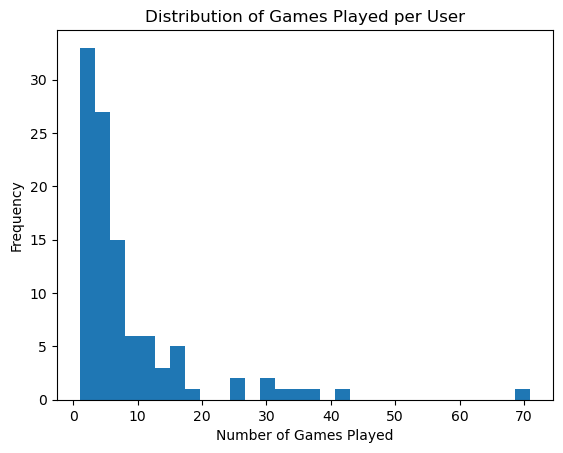

In [7]:
# Descriptive statistic of main variables.

# Distribution of games played per user

user_game_counts = game_df.groupby("user_id").size()
plt.hist(user_game_counts, bins=30)
plt.xlabel("Number of Games Played")
plt.ylabel("Frequency")
plt.title("Distribution of Games Played per User")
plt.show()

In [8]:
game_df.loc[game_df["game_duration"] > 500, "game_id"]

82    419
Name: game_id, dtype: int64

An outlier in game duration was identified. This is game id 419, and it was probably due to a bug (game freeze?).

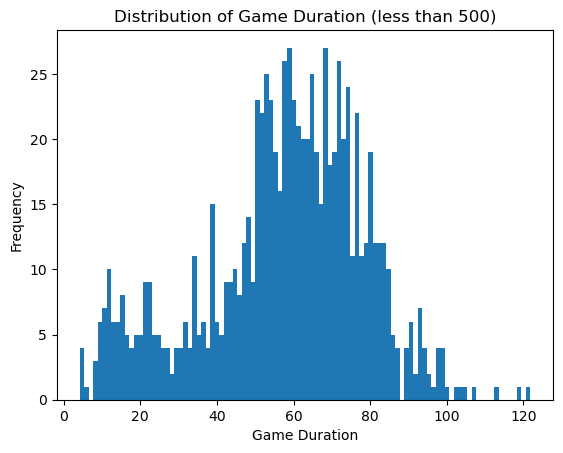

In [9]:
# Distribution of game duration
import matplotlib.pyplot as plt

plt.hist(game_df.loc[game_df["game_duration"] < 500, "game_duration"], bins=100)
plt.xlabel("Game Duration")
plt.ylabel("Frequency")
plt.title("Distribution of Game Duration (less than 500)")
plt.show()

In [10]:
# Distribution of games played per level
game_df.groupby("level").size()

level
1    511
2    250
3     77
4     33
5      9
dtype: int64

In [11]:
# random_record_id = psychometrics_df["record_id"].sample(n=1).iloc[0]
# psychometrics_df.loc[psychometrics_df["record_id"] == random_record_id]

In [12]:
bisbas_df = psychometrics_df.loc[
    ~psychometrics_df["redcap_repeat_instrument"].isin(["flow", "sam"])
    & psychometrics_df["consent_timestamp"].notna()
    & (psychometrics_df["record_id"] > 60)
]

bisbas_df = bisbas_df.iloc[:, 5:34]

bisbas_df.describe()

,age,gender,gender_other,edu,experience,consent_answer,bis_1,bis_2,bis_3,bis_4,...,rew_4,rew_5,drive_1,drive_2,drive_3,drive_4,fun_1,fun_2,fun_3,fun_4
count,112.000000,112.000000,0.0,112.000000,105.000000,112.000000,111.000000,111.000000,111.000000,111.000000,...,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,28.705357,1.758929,NaN,4.241071,1.152381,0.991071,2.900901,3.153153,3.027027,3.279279,...,3.378378,3.117117,2.558559,2.567568,2.495495,1.981982,2.819820,2.900901,3.072072,2.531532
std,7.831144,0.700650,NaN,0.960907,0.361113,0.094491,0.762233,0.776919,0.768227,0.776603,...,0.661322,0.759650,0.794123,0.837980,0.761265,0.738327,0.875922,0.797211,0.709823,0.784159
min,20.000000,1.000000,NaN,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,23.750000,1.000000,NaN,4.000000,1.000000,1.000000,2.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,2.000000,2.000000,2.000000,1.500000,2.000000,2.000000,3.000000,2.000000
50%,26.500000,2.000000,NaN,4.000000,1.000000,1.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000
75%,31.000000,2.000000,NaN,5.000000,1.000000,1.000000,3.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000
max,59.000000,4.000000,NaN,6.000000,2.000000,1.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
